
# Blue Bikes
### Blue Bikes (https://www.bluebikes.com/) is a public bike share system that operates in the Greater Boston area.

We are interested in exploring the bike share operations from the data available on https://www.bluebikes.com/system-data. And we  utilize the “Bluebikes trip history data” as well as “the list of GPS coordinates and number of docks for each station” available on the website.


In [1]:
# Build up a Full Dataframe 
import os
import pandas as pd

path = os.getcwd()
files = os.listdir(path)

# Find CSV files
csv_files = [f for f in files if f[-8:] == 'data.csv']

# Initialize empty dataframe
full_df = pd.DataFrame()

#Insert all the tripdata into the dataframe
for f in csv_files:
    data = pd.read_csv(f)
    full_df = full_df.append(data)
    
print(full_df.head())

   tripduration            starttime             stoptime  start station id  \
0           211  2015-06-01 00:07:07  2015-06-01 00:10:39                88   
1           834  2015-06-01 00:13:48  2015-06-01 00:27:43                 5   
2          1587  2015-06-01 00:16:35  2015-06-01 00:43:02                41   
3           224  2015-06-01 00:41:41  2015-06-01 00:45:26                22   
4           539  2015-06-01 00:44:54  2015-06-01 00:53:53                22   

                               start station name  start station latitude  \
0   Inman Square at Vellucci Plaza / Hampshire St               42.374035   
1              Northeastern U / North Parking Lot               42.341814   
2  Packard's Corner - Comm. Ave. at Brighton Ave.               42.352261   
3               South Station - 700 Atlantic Ave.               42.352175   
4               South Station - 700 Atlantic Ave.               42.352175   

   start station longitude  end station id  \
0               

In [2]:
# Add a column to store month_year data
full_df['Month_Year'] = pd.to_datetime(full_df['starttime']).dt.to_period('M')
# Count number of trip(row) for each month
a = full_df['Month_Year'].value_counts().sort_index()
# Make it as a dataframe
monthly_df = pd.DataFrame({'Actual_Number' : a})

## Plot a line chart to get some sense for the tripdata

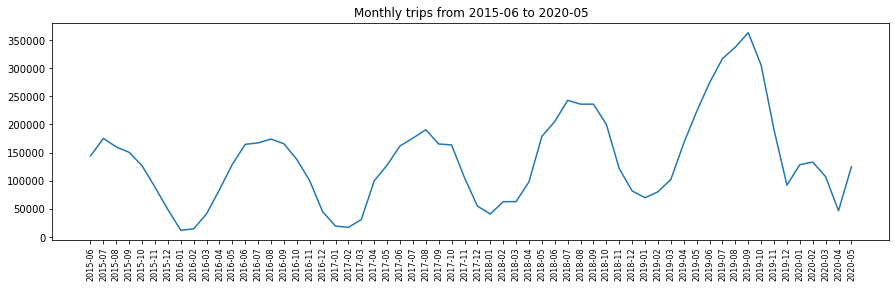

In [3]:
# Plot the line chart
import matplotlib.pyplot as plt
x= monthly_df.index.strftime("%Y-%m")
plt.figure(figsize=(15,4))
plt.plot(x, monthly_df['Actual_Number'])
plt.title('Monthly trips from 2015-06 to 2020-05')
plt.xticks(rotation=90, fontsize=8)
plt.show()

## Any observed patterns, e.g., trend, seasonality, and shocks?

Referring to the above plot, we can see an overall upward trend year by year from 2017 to 2019.
In terms of seasonality, we can see that a lower season during from Q4 of the year to the Q1 of the next year, then a high season in Q2 and Q3.
However, we can see a shock in the beginning of 2020, a sudden drop in April 2020, followed by a recovery in May 2020.
The upward trend could also be shown with 12-month moving-average line plot below:

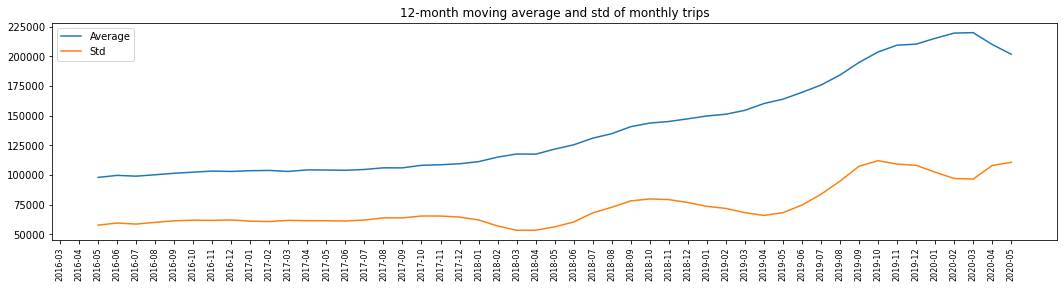

In [4]:
# Plot the line chart for 12-month moving average and std
a_average = list(monthly_df['Actual_Number'].rolling(12).mean())
a_std = list(monthly_df['Actual_Number'].rolling(12).std())
plt.figure(figsize=(18,4))
plt.plot(x,a_average, label='Average')
plt.plot(x,a_std, label='Std')
plt.title('12-month moving average and std of monthly trips')
plt.xticks(rotation=90, fontsize=8)
plt.legend()
plt.show()

## 3. We would want to use (1) Moving Average, (2) Exponential Smoothing and (3) Holt's method to forecast the monthly trips from 2019-06 to 2020-05 

#### (Note: when forecasting for month t+1, the history from 2015-06 up to month t are utilized.)

### a.  3-month moving average:

2019-06    164049.000000
2019-07    221266.666667
2019-08    271345.666667
2019-09    309465.333333
2019-10    339186.333333
2019-11    335377.333333
2019-12    286482.666667
2020-01    196157.000000
2020-02    137188.333333
2020-03    118013.666667
2020-04    123061.000000
2020-05     95792.666667
Freq: M, Name: MA_3_pred, dtype: float64


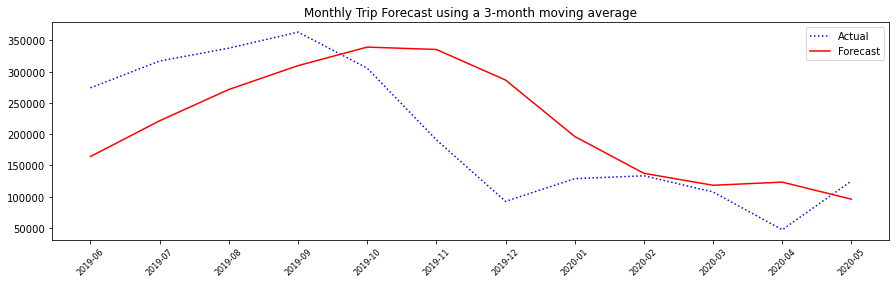

In [5]:
# Set up 3-month moving average
MA_3_pred= list(a.rolling(3).mean())
del MA_3_pred[-1]

#Insert MA_3_pred as column
monthly_df.loc[monthly_df.index[1:], 'MA_3_pred'] = MA_3_pred

#Print out the forecastfor MA_3_pred
print(monthly_df['MA_3_pred'].loc[monthly_df.index > '2019-05'])
#Filter the period from 2019-06 to 2020-05
filtered_monthly_df = monthly_df.loc[monthly_df.index > '2019-05']

#Plot the forecast
plt.figure(figsize=(15,4))
x_1= filtered_monthly_df.index.strftime("%Y-%m")
plt.plot(x_1, filtered_monthly_df['Actual_Number'], label='Actual', color='blue', linestyle='dotted')
plt.plot(x_1, filtered_monthly_df['MA_3_pred'], label='Forecast', color='red')
plt.title('Monthly Trip Forecast using a 3-month moving average')
plt.legend()
plt.xticks(rotation=45, fontsize=8)
plt.show()

### Exponential smoothing with a smoothing constant α=0.5

In [6]:
from statsmodels.tsa.api import SimpleExpSmoothing

SES_forecast=[]

for i in range (0,12):
    train_data= monthly_df.loc[monthly_df.index - i < '2019-06']
    SES_model = SimpleExpSmoothing(train_data['Actual_Number']).fit(smoothing_level = 0.5)
    SES_forecast.append(SES_model.forecast(1))

In [7]:
monthly_df.loc[monthly_df.index[48:], 'SES_forecast'] = SES_forecast

2019-06    177127.449306
2019-07    225574.724653
2019-08    271252.862326
2019-09    304347.931163
2019-10    333766.465582
2019-11    319635.232791
2019-12    255197.116395
2020-01    173702.558198
2020-02    151150.279099
2020-03    142192.639549
2020-04    124771.319775
2020-05     85782.159887
Freq: M, Name: SES_forecast, dtype: float64


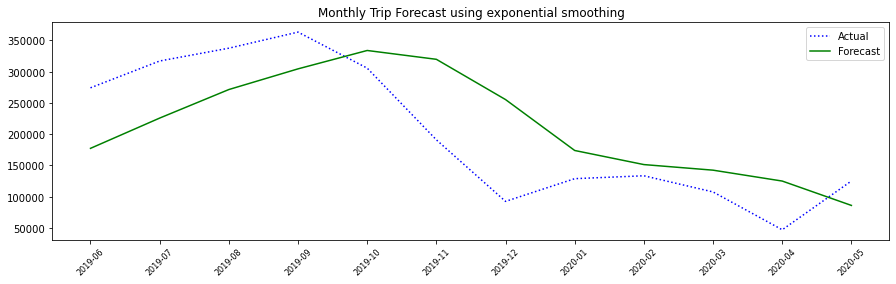

In [8]:
#Print the forecast
print(monthly_df['SES_forecast'].loc[monthly_df.index > '2019-05'])


#Plot the forecast
plt.figure(figsize=(15,4))
x_2= monthly_df.index.strftime("%Y-%m")
plt.plot(x_1, filtered_monthly_df['Actual_Number'], label='Actual', color='blue', linestyle='dotted')
plt.plot(x_2, monthly_df['SES_forecast'], label='Forecast', color='green')
plt.title('Monthly Trip Forecast using exponential smoothing')
plt.legend()
plt.xticks(rotation=45, fontsize=8)
plt.show()

### Holt’s method with α=0.3 and β=0.1

In [9]:
from statsmodels.tsa.api import Holt

holt_forecast=[]

for j in range(0,12):
    train_data= monthly_df.loc[monthly_df.index - j < '2019-06']
    Holt_method = Holt(train_data['Actual_Number']).fit(smoothing_level=0.3, smoothing_slope=0.1, optimized=False)
    holt_forecast.append(Holt_method.forecast(1))



In [10]:
monthly_df.loc[monthly_df.index[48:], 'Holt_forecast'] = holt_forecast

2019-06    155681.560267
2019-07    196215.892896
2019-08    241084.078949
2019-09    281536.176818
2019-10    320024.710022
2019-11    329226.761963
2019-12    297090.665464
2020-01    238883.617950
2020-02    205747.116152
2020-03    181767.301409
2020-04    154983.412046
2020-05    114821.877131
Freq: M, Name: Holt_forecast, dtype: float64


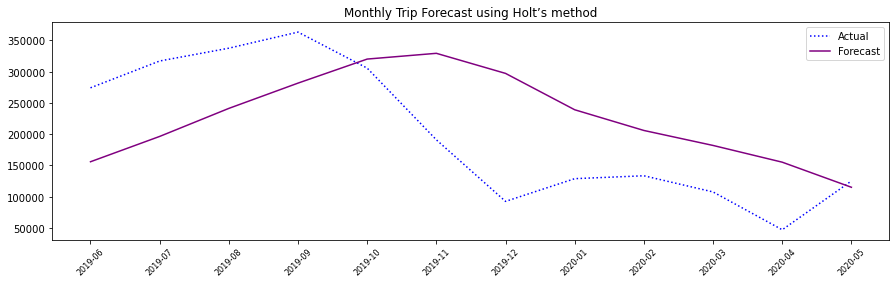

In [11]:
#Print out the forecast
print(monthly_df['Holt_forecast'].loc[monthly_df.index > '2019-05'])
#Plot the forecast
plt.figure(figsize=(15,4))
x_2= monthly_df.index.strftime("%Y-%m")
plt.plot(x_1, filtered_monthly_df['Actual_Number'], label='Actual', color='blue', linestyle='dotted')
plt.plot(x_2, monthly_df['Holt_forecast'], label='Forecast', color='purple')
plt.title('Monthly Trip Forecast using Holt’s method')
plt.legend()
plt.xticks(rotation=45, fontsize=8)
plt.show()

## All three methods together with the actual trips for the periods 2019-06 to 2020-05

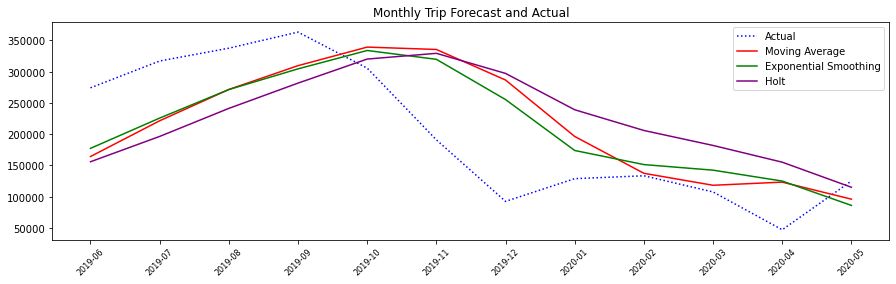

In [12]:
#Filter the period from 2019-06 to 2020-05
filtered2_monthly_df = monthly_df.loc[monthly_df.index > '2019-05']

#Plot the forecast
plt.figure(figsize=(15,4))
x_3= filtered_monthly_df.index.strftime("%Y-%m")
plt.plot(x_3, filtered2_monthly_df['Actual_Number'], label='Actual', color='blue',linestyle='dotted')
plt.plot(x_3, filtered2_monthly_df['MA_3_pred'], label='Moving Average', color='red')
plt.plot(x_3, filtered2_monthly_df['SES_forecast'], label='Exponential Smoothing', color='green')
plt.plot(x_3, filtered2_monthly_df['Holt_forecast'], label='Holt', color='purple')
plt.title('Monthly Trip Forecast and Actual')
plt.legend()
plt.xticks(rotation=45, fontsize=8)
plt.show()

### Evaluate the above forecasting methods using MAD (Mean Absolute Deviation) and MAPE

In [13]:
# Calculate MAD
import numpy as np
from sklearn.metrics import mean_absolute_error
MAD_MA = mean_absolute_error(np.array(filtered2_monthly_df['Actual_Number']),np.array(filtered2_monthly_df['MA_3_pred']))
MAD_SES = mean_absolute_error(np.array(filtered2_monthly_df['Actual_Number']),np.array(filtered2_monthly_df['SES_forecast']))
MAD_Holt = mean_absolute_error(np.array(filtered2_monthly_df['Actual_Number']),np.array(filtered2_monthly_df['Holt_forecast']))

print("MAD of Moving Average Method:",MAD_MA)
print("MAD of Exponential Smoothing Method:",MAD_SES)
print("MAD of Holt's Method:",MAD_Holt)

MAD of Moving Average Method: 73796.66666666667
MAD of Exponential Smoothing Method: 70695.29033772778
MAD of Holt's Method: 95866.41657870775


In [14]:
# Calculate MAPE

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

MAPE_MA = mean_absolute_percentage_error(np.array(filtered2_monthly_df['Actual_Number']),np.array(filtered2_monthly_df['MA_3_pred']))
MAPE_SES = mean_absolute_percentage_error(np.array(filtered2_monthly_df['Actual_Number']),np.array(filtered2_monthly_df['SES_forecast']))
MAPE_Holt = mean_absolute_percentage_error(np.array(filtered2_monthly_df['Actual_Number']),np.array(filtered2_monthly_df['Holt_forecast']))

print("MAPE of Moving Average Method:",MAPE_MA,"%")
print("MAPE of Exponential Smoothing Method:",MAPE_SES,"%")
print("MAPE of Holt's Method:",MAPE_Holt,"%")

MAPE of Moving Average Method: 54.49525413832923 %
MAPE of Exponential Smoothing Method: 52.708727368293694 %
MAPE of Holt's Method: 73.38497610269354 %


## Discuss the performance and suggestions for improvement

Comparing both MAD and MAPE, it is suggested to use Exponential Smoothing Method since it gives the lowest ones. However, all three methods currently gives a rather high MAD and MAPE (e.g. MAPEs of over 50% for all three methods). 
The main reason for the bad performance is that the monthly trip data is considered to be non-stationary. As mentioned above, we observed trend and seasonality in the line chart of monthly trips from 2015-06 to 2020-05. We could apply different techniques (take difference, take log , take square root or etc.) to the current dataset and transform it to become a stationary dataset for further forecast.

Also, we may consider to adjust the numer of months to roll in moving average method , the $\alpha$ in Exponential Smoothing Method as well as $\alpha$ and $\beta$ in Holt's method to give a better result.

## Use the histories from 2015-06 to 2019-05 to forecast the monthly trips from 2019-06 to 2020-05 using Holt-Winters’ method and ARIMA
### Show the time series decomposition for periods 2015-06 to 2019-05 to identify trend and seasonality


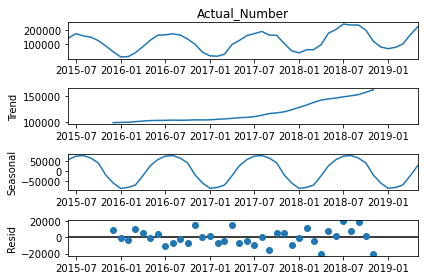

In [15]:
# Subset the data and convert it to dataframe
monthly_df_train = monthly_df.loc[monthly_df.index < '2019-06']
Actual_Number_train = pd.DataFrame({'Actual_Number' : monthly_df_train['Actual_Number']})

# Seasonal_decompose does not accept PeriodIndex
Actual_Number_train.index=Actual_Number_train.index.to_timestamp()

# Time Series Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(Actual_Number_train['Actual_Number'], model='additive', period = 12)
result.plot()
plt.show()

An upward trend and a seasonaility with 12-moth length are observed. 

### Forecasts using Holt-Winters’ method


In [16]:
from statsmodels.tsa.api import ExponentialSmoothing
ES_monthly = ExponentialSmoothing(Actual_Number_train,trend='add', seasonal='add',seasonal_periods = 12).fit()
HW_forecast=ES_monthly.forecast(12)

# Make it as a dataframe
HW_forecast = pd.DataFrame({'HW_forecast' : HW_forecast})
#Print out HW forecast result
print(HW_forecast)

              HW_forecast
2019-06-01  248685.769137
2019-07-01  266296.090464
2019-08-01  264739.676502
2019-09-01  250661.010894
2019-10-01  225253.827136
2019-11-01  180562.702372
2019-12-01  139195.612800
2020-01-01  118193.665717
2020-02-01  122466.988455
2020-03-01  139677.318707
2020-04-01  196697.441474
2020-05-01  242219.589876


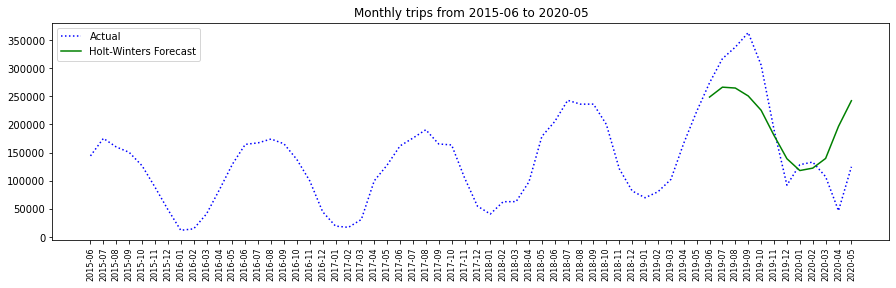

In [17]:
#Plot the forecast
x1_1= HW_forecast.index.strftime("%Y-%m")
plt.figure(figsize=(15,4))
plt.plot(x, monthly_df['Actual_Number'], label='Actual',linestyle='dotted', color='blue' )
plt.plot(x1_1, HW_forecast['HW_forecast'], label='Holt-Winters Forecast', color='green')
plt.title('Monthly trips from 2015-06 to 2020-05')
plt.xticks(rotation=90, fontsize=8)
plt.legend()
plt.show()

### Identification of best fit ARIMA model


In [18]:
#Model set-up
import pmdarima as pm
model = pm.auto_arima(Actual_Number_train['Actual_Number'],seasonal = True, m=12, suppress_warnings=True)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -394.273
Date:                            Tue, 15 Sep 2020   AIC                            794.545
Time:                                    22:54:23   BIC                            799.211
Sample:                                         0   HQIC                           796.156
                                             - 48                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2913      0.146     -1.999      0.046      -0.577      -0.006
ma.S.L12      -0.2414      0.106     -2.272      0.023      -0.450      -0.033
sigma2      3.216e+08   3.19e-11   1.01e+19      0.000    3.22e+08    3.22e+08
===================================================================================
Ljung-Box (Q):                       28.59   Jarque-Bera (JB):                 0.42
Prob(Q):                              0.73   Prob(JB):                         0.81
Heteroskedasticity (H):               0.93   Skew:                             0.20
Prob(H) (two-sided):                  0.90   Kurtosis:                         2.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.96e+35. Standard errors may be unstable.
"""

#### The above summary gives a result showing: SARIMAX(0, 1, 1)x(0, 1, 1, 12).
Therefore, the model identifies that differencing order of 1 and MA(1) for non-seasonal order and differencing order of 1 and MA(1) for seasonal order for the best-fit purpose.

### Plot ACF and PACF of fitted residuals to verify whether there is MA/AR effect left

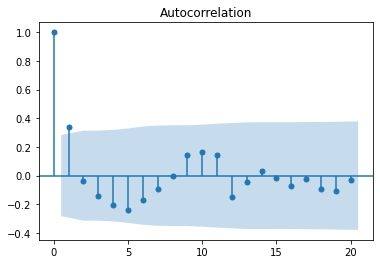

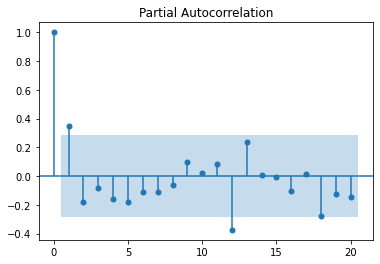

In [19]:
# Calculate residuals
model.resid()
# Plot ACF and PACF for residuals of ARIMA model 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(model.resid(),lags=20)
plt.show()
plot_pacf(model.resid(),lags=20)
plt.show()

### Forecast the trips for 2019-06 to 2020-05 using the best fit ARIMA model and plot the predictions with 95% confidence intervals


In [20]:
# Forecast the trips using the best fit ARIMA model
pred, conf = model.predict(12, return_conf_int=True,alpha=0.05)

In [21]:
#Set up a dataframe to contain the prediction and confidence interval
Test = pd.DataFrame()

Test['test_periods'] = pd.date_range('2019-06-01','2020-05-01',  freq='MS').strftime("%Y-%m").tolist()
Test['prediction'] = list(pred)
Test['lower_bounds'] = [i[0] for i in conf ]
Test['upper_bounds'] = [i[1] for i in conf ]

print(Test)

   test_periods     prediction   lower_bounds   upper_bounds
0       2019-06  253677.067993  218530.421773  288823.714212
1       2019-07  285174.057938  242095.781551  328252.334326
2       2019-08  282835.750274  233074.429414  332597.071134
3       2019-09  277808.712381  222161.248725  333456.176037
4       2019-10  248632.182892  187664.229268  309600.136516
5       2019-11  176197.127586  110337.105366  242057.149806
6       2019-12  134174.157188   63761.135063  204587.179313
7       2020-01  120887.230512   46198.243083  195576.217941
8       2020-02  132860.413941   54127.345899  211593.481982
9       2020-03  150413.520776   67834.182144  232992.859408
10      2020-04  209159.107926  122904.842211  295413.373641
11      2020-05  268465.554436  178686.652801  358244.456072


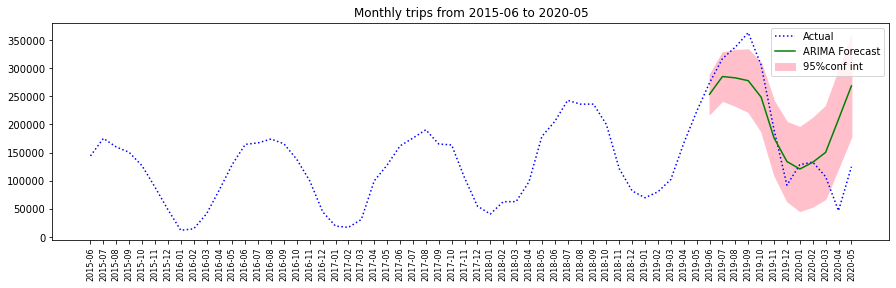

In [22]:
# Plot the predictions with 95% confidence intervals
x1_1= HW_forecast.index.strftime("%Y-%m")
plt.figure(figsize=(15,4))
plt.plot(x, monthly_df['Actual_Number'], label='Actual',linestyle='dotted', color='blue' )
plt.plot(Test['test_periods'], Test['prediction'], label='ARIMA Forecast', color='green')
plt.fill_between(Test['test_periods'], Test['lower_bounds'], Test['upper_bounds'], color='pink', label='95%conf int')
plt.title('Monthly trips from 2015-06 to 2020-05')
plt.xticks(rotation=90, fontsize=8)
plt.legend()
plt.show()

## Now we want to understand the key factors that affects the total daily ridership 2019-01 to 2019-12. 

### Auxiliary data sets and discuss your findings 
Weather data: https://www.meteoblue.com/en/weather/archive/era5/boston_united-states-of-america_4930956

In [23]:
#Set up a dataframe for daily trip in 2019
# 1. Add a column to store date_month_year data
full_df['Date_Month_Year'] = pd.to_datetime(full_df['starttime']).dt.to_period('D')
# 2. Count number of trip(row) for each month
b = full_df['Date_Month_Year'].value_counts().sort_index()
# 3. Make it as a dataframe
daily_df = pd.DataFrame({'Total_Daily' : b})

In [24]:
# 4. Subset it to year 2019 only
daily_df_2019 = daily_df.loc[(daily_df.index > '2018-12-31') & (daily_df.index < '2020-01-01')]
print("Number of data:",daily_df_2019.count())

Number of data: Total_Daily    364
dtype: int64


Referring to the dataset in 2019, we can see that one day is missing, 20 January 2019. The reason was due to a heavy snow that day in Boston. For more details, we may refer to  https://www.bluebikes.com/blog/winter-shutdown. We can see that weather could be a key factor that affects the daily ridership. Other than time-series analysis, we can also consider the weather factor into the model (as an exogenous data).

In [25]:
#Add several weather indicators into the dataframe as columns

#Read CSV
# Data cleansing was done in excel
weather = pd.read_csv('weather2019.csv')
weather['timestamp'] = pd.to_datetime(weather['timestamp']).dt.to_period('D')
weather.set_index('timestamp', inplace=True)

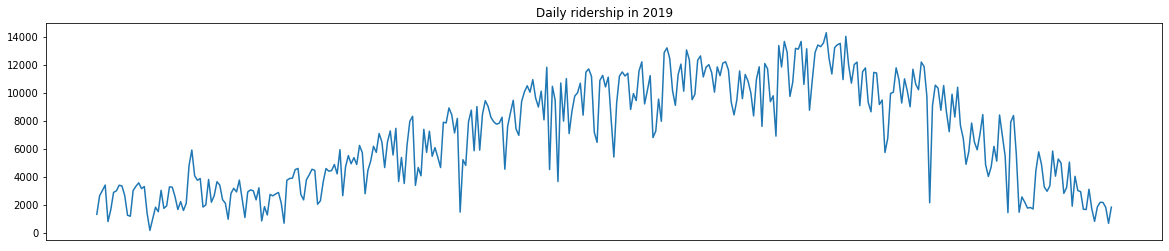

In [26]:
#Merge daily_df_2019 and weather
df_2019 = pd.merge(weather, daily_df_2019, how='inner', left_index=True, right_index=True)

#Plot the line chart of daily ridership
x2= df_2019.index.strftime("%m-%d")
plt.figure(figsize=(20,4))
plt.plot(x2, df_2019['Total_Daily'])
plt.xticks([])
plt.title('Daily ridership in 2019')
plt.show()

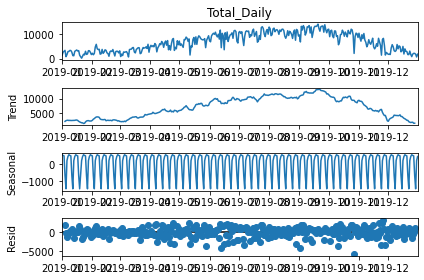

In [27]:
df_2019.index=df_2019.index.to_timestamp()


# Time Series Decomposition
# Seasonality of 7-day may be applicable in this case
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_2019['Total_Daily'], period = 7)
result.plot()
plt.show()

In [28]:
#Try a few weather indicators
weather_indicators =  df_2019[['Boston Temperature_mean','Boston Precipitation Total','Boston Evapotranspiration','Boston Sunshine Duration','Boston Relative Humidity_mean']]

#Find best-fit ARIMAX model
model2 = pm.auto_arima(df_2019['Total_Daily'], suppress_warnings=True,exogenous = weather_indicators, seasonal=True, m=7)
print(model2.summary())


                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  364
Model:             SARIMAX(2, 1, 2)x(1, 0, 2, 7)   Log Likelihood               -3057.928
Date:                           Tue, 15 Sep 2020   AIC                           6141.856
Time:                                   22:56:32   BIC                           6192.484
Sample:                                        0   HQIC                          6161.980
                                           - 364                                         
Covariance Type:                             opg                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Boston Temperature_mean         116.0811     22.498      5.160      0.000      71.98

## Findings(Weather)

Referring to the above result, we can see that the temperature, the precipitation and rate of evapotranspiration are relatively critical weather factors. People tend to like go cycling more when the temperature is higher (given that Boston is considered to be one of cold city in USA), when it is not rainy (precipitation is low) and when the road is dry enough to cycle (evapotranspiration is high).

In [29]:
# Maybe try to see how federal holiday and weekend affect the daily ridership
# Binary Data: Federal Holiday[1:Yes; 0:No] ; Weekend[1:Yes; 0:No] 

Holiday = pd.read_csv('Holidayandweekend2019.csv')
Holiday['timestamp'] = pd.to_datetime(Holiday['timestamp']).dt.to_period('D')
Holiday.set_index('timestamp', inplace=True)
#To make index type consistent
Holiday.index=Holiday.index.to_timestamp()


#Merge daily_df_2019 and weather
df_2019_v2 = pd.merge(df_2019, Holiday, how='inner', left_index=True, right_index=True)


#Try to add Holiday and weekend and keep temperature, precipitation and evapotranspiration variables
exog2 = df_2019_v2[['Boston Temperature_mean','Boston Precipitation Total','Boston Evapotranspiration','Federal Holiday','Weekend']]

#Find best-fit ARIMAX model
model3 = pm.auto_arima(df_2019_v2['Total_Daily'], suppress_warnings=True,exogenous = exog2, seasonal=True, m=7)
print(model3.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  364
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 7)   Log Likelihood               -3059.821
Date:                           Tue, 15 Sep 2020   AIC                           6147.643
Time:                                   22:58:08   BIC                           6202.164
Sample:                                        0   HQIC                          6169.315
                                           - 364                                         
Covariance Type:                             opg                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Boston Temperature_mean      145.1032     19.561      7.418      0.000     106.765     183

## Findings (Weekend and Holiday)

We can see that whether it is weekend or federal holiday affects the daily ridership much. The negative coefficient for both variables suggest that people may usually ride Bluebike for the purpose of commuting to work or going to school. Therefore, the marketing team in Bluebike may want to do more promotion or price discount during holiday and weekend to increase its daily ridership.

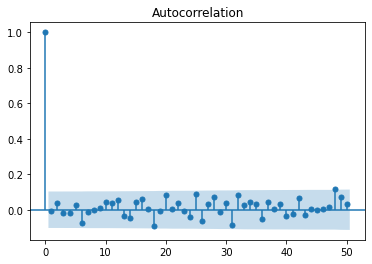

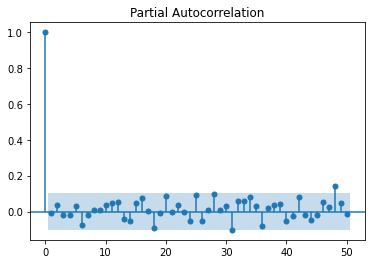

In [30]:
# Calculate residuals
model3.resid()
# Plot ACF and PACF for residuals of SARIMAX model to check if any anomaly
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(model3.resid(),lags=50)
plt.show()
plot_pacf(model3.resid(),lags=50)
plt.show()

## Now we want to understand the key factors that explains the difference in the (average daily) ridership between different pairs of origin and destination in 2019

In [31]:
#Create a dataframe to calculate the average daily ridership between different pairs
daily_df_2019_2 = full_df.loc[(full_df['Date_Month_Year'] > '2018-12-31') & (full_df['Date_Month_Year'] < '2020-01-01')]
daily_df_2019_2.loc[ : ,'startpoint_str'] = daily_df_2019_2['start station id'].astype(str)
daily_df_2019_2.loc[ : ,'endpoint_str'] = daily_df_2019_2['end station id'].astype(str)

D:\Applications\Anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
D:\Applications\Anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [32]:
#Create a new column to store pair information
daily_df_2019_2.loc[:,'startpoint_endpoint'] = daily_df_2019_2[['startpoint_str', 'endpoint_str']].agg('-'.join, axis=1)
#Count for each pair
daily_df_2019_2.loc[:,'count'] = daily_df_2019_2.groupby('startpoint_endpoint')['startpoint_endpoint'].transform('count')
daily_df_2019_2.set_index('startpoint_endpoint', inplace=True)
#Subset a dataframe to sore the count and station information
station_and_count = daily_df_2019_2[['count', 'start station id', 'end station id']]
station_and_count_dropped = station_and_count.drop_duplicates()

In [33]:
#New column to calculate daily average (count column / 365)
station_and_count_dropped.loc[: ,'Average_Daily'] = station_and_count_dropped['count']/365
station_and_count_dropped = station_and_count_dropped.reset_index()
print(station_and_count_dropped)
print(station_and_count_dropped.info())

      startpoint_endpoint  count  start station id  end station id  \
0                  80-179   3708                80             179   
1                 117-189    257               117             189   
2                   68-96    711                68              96   
3                  89-334    223                89             334   
4                  73-367    241                73             367   
...                   ...    ...               ...             ...   
61398             381-425      1               381             425   
61399             272-404      1               272             404   
61400              414-99      1               414              99   
61401              20-408      1                20             408   
61402             344-125      1               344             125   

       Average_Daily  
0          10.158904  
1           0.704110  
2           1.947945  
3           0.610959  
4           0.660274  
...              ... 

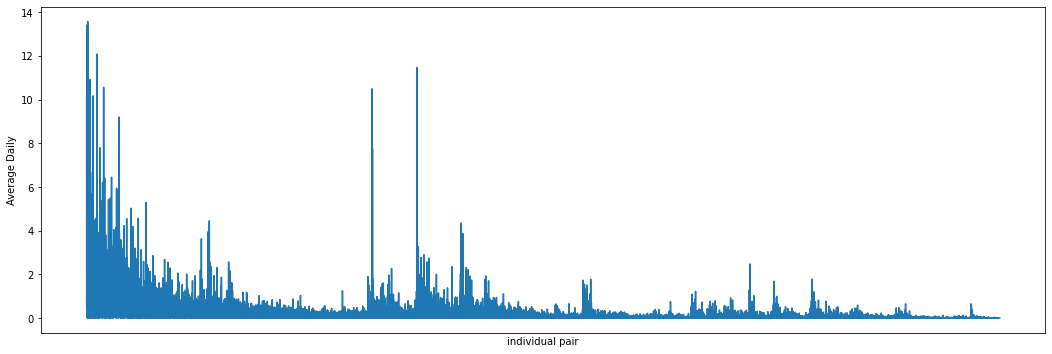

In [34]:
# Explore distribution of the daily average 
# most of them are small values, with only a handful of them is greater than 5
fig, ax1 = plt.subplots(figsize=(18, 6))
plt.plot(station_and_count_dropped['Average_Daily'])
plt.xticks([])
plt.xlabel('individual pair')
plt.ylabel('Average Daily')
plt.show()

In [35]:
# Add some variables into the dataframe
# e.g. number of docks at start station and number of docks at end station, and distancae between them
station = pd.read_csv('Stations.csv')
print(station.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325 entries, 0 to 324
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station Id   325 non-null    int64  
 1   Name         325 non-null    object 
 2   Latitude     325 non-null    float64
 3   Longitude    325 non-null    float64
 4   District     325 non-null    object 
 5   Public       325 non-null    object 
 6   Total docks  325 non-null    int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 17.9+ KB
None


In [36]:
# 1. Add num of docks and coordinate regarding start station
merged = pd.merge(station_and_count_dropped, station[['Station Id', 'Total docks','Latitude','Longitude']], left_on='start station id', right_on= 'Station Id')
merged = merged.rename(columns={'Total docks': 'Start_station_dock', 'Latitude':'Start_Latitude', 'Longitude':'Start_Longitude'})

In [37]:
# 2. Add num of docks and coordinate regarding end station
merged2 = pd.merge(merged, station[['Station Id', 'Total docks','Latitude','Longitude']], left_on='end station id', right_on= 'Station Id')
merged2 = merged2.rename(columns={'Total docks': 'End_station_dock', 'Latitude':'End_Latitude', 'Longitude':'End_Longitude'})

In [38]:
print(merged2.head())

  startpoint_endpoint  count  start station id  end station id  Average_Daily  \
0              80-179   3708                80             179      10.158904   
1             117-179    160               117             179       0.438356   
2              68-179   2067                68             179       5.663014   
3              89-179     12                89             179       0.032877   
4              73-179    137                73             179       0.375342   

   Station Id_x  Start_station_dock  Start_Latitude  Start_Longitude  \
0            80                  35       42.362131       -71.091156   
1           117                  19       42.366088       -71.086336   
2            68                  19       42.365070       -71.103100   
3            89                  19       42.379011       -71.119945   
4            73                  15       42.373231       -71.120886   

   Station Id_y  End_station_dock  End_Latitude  End_Longitude  
0           179

In [39]:
#3. Calculate the distance by Latitude and Longitude of starting and ending station
import math as math
from math import radians, sin, cos, acos

#radius of the Earth (fixed)
R = 6373.0

distance=[]

for i in range (0,58895):
#coordinates
    lat1 = math.radians(merged2['Start_Latitude'][i])
    lon1 = math.radians(merged2['Start_Longitude'][i])
    lat2 = math.radians(merged2['End_Latitude'][i])
    lon2 = math.radians(merged2['End_Longitude'][i])

#change in coordinates
    dlon = lon2 - lon1
    dlat = lat2 - lat1

#Haversine formula
    Haversine = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(Haversine), math.sqrt(1 - Haversine))
    dist = R * c
    distance.append(dist)

In [40]:
merged2['distance'] = distance
print(merged2.head())

  startpoint_endpoint  count  start station id  end station id  Average_Daily  \
0              80-179   3708                80             179      10.158904   
1             117-179    160               117             179       0.438356   
2              68-179   2067                68             179       5.663014   
3              89-179     12                89             179       0.032877   
4              73-179    137                73             179       0.375342   

   Station Id_x  Start_station_dock  Start_Latitude  Start_Longitude  \
0            80                  35       42.362131       -71.091156   
1           117                  19       42.366088       -71.086336   
2            68                  19       42.365070       -71.103100   
3            89                  19       42.379011       -71.119945   
4            73                  15       42.373231       -71.120886   

   Station Id_y  End_station_dock  End_Latitude  End_Longitude  distance  
0    

In [41]:
#Print the correlation matrix
print(merged2[["Average_Daily", "Start_station_dock", "End_station_dock", "distance"]].corr())

                    Average_Daily  Start_station_dock  End_station_dock  \
Average_Daily            1.000000            0.118151          0.119359   
Start_station_dock       0.118151            1.000000         -0.004347   
End_station_dock         0.119359           -0.004347          1.000000   
distance                -0.306196           -0.008112         -0.015851   

                    distance  
Average_Daily      -0.306196  
Start_station_dock -0.008112  
End_station_dock   -0.015851  
distance            1.000000  


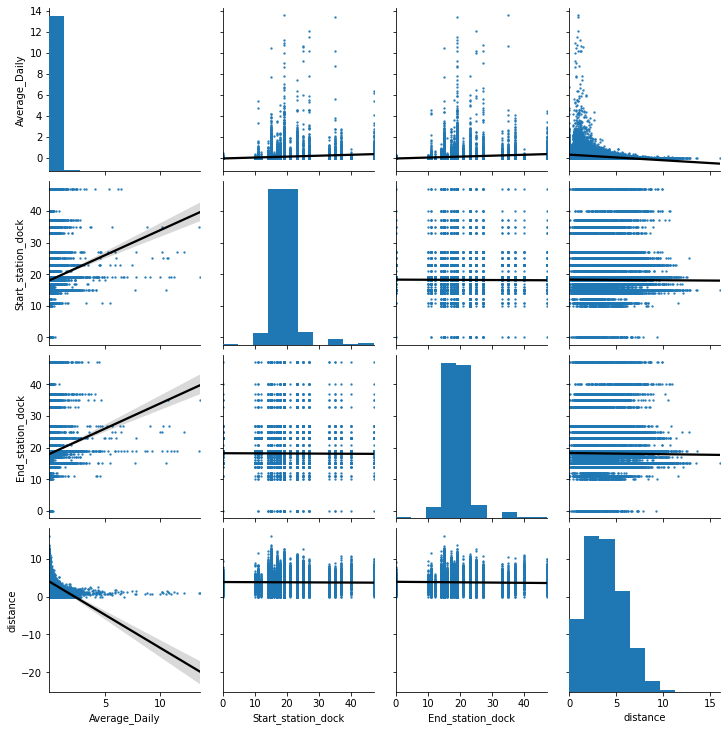

In [42]:
# visualing relationships among variables
import seaborn as sns
sns.pairplot(merged2[["Average_Daily", "Start_station_dock", "End_station_dock", "distance"]], kind="reg",plot_kws=dict(scatter_kws=dict(s=2), line_kws = {'color':'black'}))

In [43]:
#Multiple regression model
import statsmodels.formula.api as smf
merged2_model = smf.ols('Average_Daily ~ Start_station_dock + End_station_dock + distance', data =merged2).fit()
merged2_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Average_Daily   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     2686.
Date:                Tue, 15 Sep 2020   Prob (F-statistic):               0.00
Time:                        23:01:55   Log-Likelihood:                -17118.
No. Observations:               58895   AIC:                         3.424e+04
Df Residuals:                   58891   BIC:                         3.428e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.0033      0.008      0.409      0.683      -0.012       0.019
Start_station_dock     0.0086      0.000     30.063      0.000       0.008       0.009
End_station_dock       0.0086      0.000     29.766      0.000       0.008       0.009
distance              -0.0528      0.001    -78.499      0.000      -0.054      -0.051
==============================================================================
Omnibus:                   115824.108   Durbin-Watson:                   1.833
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        427931921.158
Skew:                          15.699   Prob(JB):                         0.00
Kurtosis:                     419.412   Cond. No.                         158.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Explaination on the above model

The positive coefficient of number of docks (both in start and end station) suggests that number of ridership between two stations increase when there are more docks in start station and end station. The negative coefficient in distance suggests that number of ridership decreases when distance between start station and end station is farther.

With the above result, we may suggest Bluebike to have more docks in popular start and end station, and they could also consider to do price discount on long distance trip.

However,the R-square result is still low (0.120) and therefore we could find have some more features into this model.